# Simulation: Number of collisions for ENUM-Based Regular ISD

This code applies ENUM-Based Regular ISD on random RSD instances, to verify the formula on the number of collisions.
Namely, starting from lists $L_1$ and $L_2$ with respective sizes $|L_1|$ and $|L_2|$, we estimate the average number of collisions as 

$$\frac{|L_1|\cdot |L_2|}{2^\ell}$$

Remember that the lists may have (slightly) different sizes, due to the fact that for a practical implementation of the algorithm, we have to deal with rounding issues.

The code considers several parameters, which can be chosen by the user.
Two regimes are considered:
- code rate $R > 1 - \frac{1}{e\ln(2)}$: in this case, we compute the largest w for which we have a unique solution
- code rate $R < 1 - \frac{1}{e\ln(2)}$: in this case, we consider several values of $w$

For each of these instances, we consider the values of $p$ and $\ell$ which optimize the algorithm (i.e., give the lowest time complexity).

In [6]:
reset(); 

load("PGE.sage"); #required to perform Partial Gaussian Elimination
load("list_ops.sage"); #required to merge lists

#On input an initial value for n (n_in) and code rate R, computes w
#using the uniqueness bound
def RSD_params_uniqueness_bound(n_in, R):

    n = n_in
    k = round(R*n)
    
    #compute max value of w
    b = n
    while (b**(n/b))<(2**(n-k)):
        b = b - 1
    b = b + 1
    
    #adjust parameters so that b divides n
    n = b*floor(n/b)
    k = floor(n*R)
    w = n/b
        
    return n, k, w, b

############################################################
#Generate random RSD instance (requires that n is divided by b)
def sample_rsdp_instance(n,k,b,w):

    F2 = GF(2);

    #Sample full rank parity-check matrix
    rank_H = 0;
    while rank_H < (n-k):
        H = random_matrix(F2,n-k,n);
        rank_H = rank(H);

    #Sample regular error vector
    e = matrix(F2,1,n);
    for i in range(w):
        pos = randrange(b);
        e[0,i*b+pos] = F2(1);

    #Compute syndrome
    s = H*e.transpose();

    return H, e, s;

##############################################

#Include the additional parity-check equations
def add_parity_checks(H, s, n, k, b, w):

    #Compute adapted parameters
    r = n - k;
    rp = n - k + w;
    kp = n - rp;

    ##Modify H: add partiy-check equations, remove last columns
    new_H = matrix(GF(2),rp,n);
    new_H[0:r, :] = H;
    for i in range(w):
        for j in range(b):
            new_H[r+i,i*b+j] = 1;

    new_H = new_H[:,0:n];

    ##Modify s: add new bits, corresponding to new parity-check equations
    new_s = matrix(GF(2), rp, 1);
    new_s[0:r, 0] = s;
    for i in range(w):
        new_s[r+i,0] = 1;

    return new_H, new_s;

# Theoretical estimates for ENUM-Based regular ISD
Returns the parameters to optimize the attack, as well internal quantities which will be later estimated with the simulations.

To deal with rounding issues, we are considering $\mathtt{v}\_\mathtt{f} = \left\lfloor \frac{k'+\ell}{w}\right\rfloor$ and $\mathtt{v}\_\mathtt{c} = \left\lceil \frac{k'+\ell}{w}\right\rceil$.
For the first list, we sample $\mathtt{v}\_\mathtt{f}$ coordinates from $\mathtt{w}\_\mathtt{f}\_\mathtt{left}$ blocks, and $\mathtt{v}\_\mathtt{c}$ coordinates from $\mathtt{w}\_\mathtt{c}\_\mathtt{left}$ blocks.
This way, the first list is built from vectors of length

$x_1 = \mathtt{v}\_\mathtt{f}\cdot \mathtt{w}\_\mathtt{c}\_\mathtt{left}+\mathtt{v}\_\mathtt{c}\cdot \mathtt{w}\_\mathtt{c}\_\mathtt{left}$

Analogous notation is used for the second list (the pedix $\mathtt{left}$ is replaced by $\mathtt{right}$ and the length of vectors is indicated by $x_2$). We choose these parameters so that $|x_1-x_2|$ is minized.

In [7]:
#Concrete cost estimate for enumeration based ISD
#it returns the parameters that optimize the attack, together with internal quantities:
#- parameters p and ell
#- success probability of one iteration
#- list size and number of collisions

#It takes also into account rounding issues

def enumeration_based_concrete_cost_rounding(n, k, w, b, S):

    
    k_prime = k-w;  #add parity-checks
    min_cost = 1000000000000000000000000000000;
    
    #Max parameters values to test
    p_max = 50;
    ell_max = 1000
    
    #Find min cost
    for p in range(2,min(p_max, floor(w/2))+1,2):
        for ell in range(1, min(ell_max, n-k_prime)+1):
            
                
            v = floor((k_prime+ell)/w)
                        
            if (v+1)>b:
                continue;
            
            w1 = w*(v+1)-k_prime-ell
            w2 = w-w1
            
            w1_minus = floor(w1/2)
            w2_minus = ceil(w1/2)
            
            w1_plus = ceil(w2/2)
            w2_plus = floor(w2/2)
            
            pr1 = 0; L1 = 0
            for i in range(max(0, floor(p/2)-w1_plus),min(floor(p/2),w1_minus)+1):
                term = binomial(w1_minus,i)*(1-v/b)**(w1_minus-i)*(v/b)**i*binomial(w1_plus,p/2-i)*(1-(v+1)/b)**(w1_plus-(p/2-i))*((v+1)/b)**(p/2-i);
                pr1+=term;
                L1 += binomial(w1_minus,i)*binomial(w1_plus,p/2-i)*v**i*(v+1)**(p/2-i)
                
            pr2 = 0; L2 = 0
            for i in range(max(0, floor(p/2)-w2_plus),min(floor(p/2),w2_minus)+1):
                term = binomial(w2_minus,i)*(1-v/b)**(w2_minus-i)*(v/b)**i*binomial(w2_plus,p/2-i)*(1-(v+1)/b)**(w2_plus-(p/2-i))*((v+1)/b)**(p/2-i);
                pr2+=term;
                L2 += binomial(w2_minus,i)*binomial(w2_plus,p/2-i)*v**i*(v+1)**(p/2-i)

            num_coll = L1*L2*2**(-ell);

            T_iter = n*(n-k_prime)**2+n*(L1+L2+num_coll);
            p_iter = pr1*pr2;
            
            if p_iter <= 0:
                continue;
                
            cost = log(T_iter,2)-log(p_iter,2) + log(S,2);

            #update min cost  if new cost is smaller
            if cost<min_cost:
                min_cost = N(cost);
                best_params = [p, ell, v, w1_minus, w1_plus, w2_minus, w2_plus];
                internal_values = [N(log(L1,2)),N(log(L2,2)), N(log(num_coll,2)), N(p_iter)];
                #print(v_f, N(L1))
                
    return min_cost, best_params, internal_values

# Subroutines of ENUM-Based regular ISD

In [8]:
#Enumerate regular vectors for initial lists

def all_regular_initial_list(p, w_f, v_f, w_c, v_c):
    
   # print(p, w_f, v_f, w_c, v_c);
    
    vec_length = w_f*v_f + w_c*v_c; #length of the vectors we are going to enumerate
    
    all_vecs = [];
    
    #we consider i_f blocks with length v_f and weight 1, i_c = p - i_f blocks with length v_c and weight 1
    for i_f in range(p+1):
        
        i_c = p - i_f;
        
        pos_v_f = cartesian_product([range(v_f) for i in range(i_f)]);
        pos_v_c = cartesian_product([range(v_c) for i in range(i_c)]);
        
        pos_unit_vectors_f = Combinations(range(w_f), i_f);
        pos_unit_vectors_c = Combinations(range(w_c), i_c);
        
        for pos_f in pos_unit_vectors_f:
            for pos_c in pos_unit_vectors_c:
                for pos_ones_f in pos_v_f:
                    for pos_ones_c in pos_v_c:
                        
                        candidate = matrix(GF(2),1, vec_length);
                        
                        for j in range(len(pos_f)):
                            this_pos = pos_f[j]*v_f+pos_ones_f[j];
                            candidate[0, this_pos] = 1
  
                        for j in range(len(pos_c)):
                            this_pos = w_f*v_f + v_c*pos_c[j] + pos_ones_c[j];
                            candidate[0, this_pos] = 1
                            
                        all_vecs.append(candidate);
    
    return all_vecs;

######################################

#Create initial lists: takes as input the sub-parity check matrix and the list of vectors, 
#together with target syndrome and coeff_val (either 0 or 1)
def create_list_partial_sums(H_sub, list_vectors, target_s):

    list_sums = [];
    for x in list_vectors:
        s = target_s + x*H_sub.transpose();
        list_sums.append(s);

    return list_sums;
#######################################################

#Find collisions and return list of (merged) vectors
def merge_lists(list_sums_left, list_sums_right, all_vecs_left, all_vecs_right):
    
        
    indexes = colliding_indexes(list_sums_left, list_sums_right);    

    new_list_vectors = [];
    for i in range(len(indexes)):

        new_vector = block_matrix(GF(2),1,2,[all_vecs_left[indexes[i][0]], all_vecs_right[indexes[i][1]]]);
        new_list_vectors.append(new_vector);
    
    return new_list_vectors;


###################################################
#Sample regular permutation 
def ENUM_sample_regular_permutation(n, b, v_f, v_c, w_f_left, w_c_left, w_f_right, w_c_right):
    
   # print(v_f, v_c, w_f_left, w_c_left, w_f_right, w_c_right);
    P_list_left = sample_regular_permutation(n, b, v_f, v_c, w_f_left, w_c_left, 0);
    P_list_right = sample_regular_permutation(n, b, v_f, v_c, w_f_right, w_c_right, b*(w_f_left + w_c_left));
    
    for i in P_list_right:
        P_list_left.append(i);
    
    
    #Now, place the remaining coordinates (i.e., those that will be move to the last n-k' positions)
    for i in range(n):
        if i not in P_list_left:
            P_list_left.append(i);
    
    #Create permutation matrix out of P
    P = matrix(GF(2),n,n);
    for i in range(n):
        P[P_list_left[i], i] = 1;
    

    return P;

##################################################

#Sample regular permutation
#Sample v_f coordinates from w_f blocks, v_c coordinates from w_c blocks and move them in first positions;
#These coordinates will constitute the information set
def sample_regular_permutation(n, b, v_f, v_c, w_f, w_c, offset):
    
    P_list = []; #regular permutation
    
    #We first sample coordinates for the w_f blocks (v_f from each block)
    for i in range(w_f):
        
        perm_of_b = Permutations(range(b)).random_element();
        for j in range(v_f):
            P_list.append(i*b+perm_of_b[j]+offset);
    
    #Now, sample coordinates for the w_c blocks (v_c from each block)
    for i in range(w_c):
        perm_of_b = Permutations(range(b)).random_element();
        for j in range(v_c):
            P_list.append((w_f+i)*b+perm_of_b[j]+offset);
    
    return P_list;

######################

#checks if input vector is regular
def check_regularity(x,b):
    n = x.ncols();
    
    is_regular = 1;
    for i in range(w):
        num_ones_in_block = x[0,i*b:(i+1)*b].list().count(1);
        if num_ones_in_block != 1:
            is_regular = 0;

    return is_regular;

# Implementation of ENUM-Based regular ISD
The implementation is only meant to be a proof of concept; it is only meant to verify the success probability, list sizes and the probabilities that the employed matrices have the desired rank 

In [9]:
######################
#ENUM-based ISD; it receives as input the H with additional equations
#It also updates the empirical estimates (last three parameters)
#It also requires the list of vectors to prepare the initial lists
#params must be formatted as [p, ell, w_f_left, w_c_left, w_f_right, w_c_right, v_f, v_c]
def ENUM_based_ISD(n, k_prime, w, b, new_H, new_s, all_vecs_left, all_vecs_right, params, num_success, num_full_rank, num_PGE_ok, avg_num_coll, min_num_coll, max_num_coll):
    
    p = params[0]; ell = params[1]; 
    w_f_left = params[2]; w_c_left = params[3]; w_f_right = params[4]; w_c_right = params[5]; 
    v_f = params[6]; v_c = params[7];
    
    ok = 0; #ok becomes 1 when a solution is found

    #Sample regular permutation
    P = ENUM_sample_regular_permutation(n, b, v_f, v_c, w_f_left, w_c_left, w_f_right, w_c_right);

    #Apply permutation to H
    perm_H = new_H*P;
    
    #Do PGE, continue only if PGE does not fail
    is_full_rank, reduced_H, reduced_s = PGE(n, n-k_prime, ell, perm_H, new_s);
    
    if is_full_rank:
        num_PGE_ok += 1;

        #create first list
        list_sums_left = create_list_partial_sums(reduced_H[0:ell,0:w_f_left*v_f+w_c_left*v_c], all_vecs_left, matrix(GF(2),1,ell));
        
        #create second list
        list_sums_right = create_list_partial_sums(reduced_H[0:ell,w_f_left*v_f+w_c_left*v_c:k-w+ell], all_vecs_right, reduced_s[0:ell].transpose());
        
        #find collisions and merge vectors
        merged_vecs = merge_lists(list_sums_left, list_sums_right, all_vecs_left, all_vecs_right);
        
        #Update max, min and average num collisions
        avg_num_coll += len(merged_vecs); #update estimate on average number of collisions
        max_num_coll = max(log(len(merged_vecs),2), max_num_coll)
        min_num_coll = min(log(len(merged_vecs),2), min_num_coll)

        ok_found = 0;
        for x in merged_vecs:
            H_sub = reduced_H[ell:,0:k_prime+ell];
            x_right = reduced_s[ell:] - H_sub*x.transpose();
            
            w_x = x_right.list().count(1);
            if w_x == w-2*p: #the vector has the right weight, continue by check
                
                perm_candidate_e = block_matrix(GF(2),1,2,[x, x_right.transpose()]);
                candidate_e = perm_candidate_e*P^-1;
                
                is_regular = check_regularity(candidate_e,b);
                if is_regular:
                    ok = 1; 
    
    num_success += ok;
    
    return num_success, num_full_rank, num_PGE_ok, avg_num_coll, max_num_coll, min_num_coll;

# Select the code parameters ($n$, $k$, $b$ and $w$) and the number of RSD instances to be generated (denoted by $\mathtt{num}\_\mathtt{instances}$)

We consider only values of the code rate $R$ such that $R>1-\frac{1}{e\ln(2)}$

The min and max considered code rates are given by $\mathtt{R}\_\mathtt{int}\_\mathtt{min}/100$ and $\mathtt{R}\_\mathtt{int}\_\mathtt{max}/100$. The step between two consecutive code rates is $\mathtt{R}\_\mathtt{step}/100$

For each considered set of parameters, we compute the highest value of $w$ for which we have a unique solution.

Considering: w/n =  0.200000000000000 , [n, k, w, b] = [100, 50, 20, 5]
Setting: p = 6, ell = 9 , |L1| = 2^9.90689059560852, |L2| = 2^9.67242534197150
log2(Num_coll): Theoretical:  10.5793159375800
Experimental values:
log2(Min_num_coll):  10.4958550268872 log2(Avg_num_coll):  10.5804847070646 , log2(Max_num_coll):  10.6510516911789
-------------------------------------------------------------------------------------
Considering: w/n =  0.166666666666667 , [n, k, w, b] = [96, 52, 16, 6]
Setting: p = 6, ell = 10 , |L1| = 2^10.3695973462787, |L2| = 2^10.3695973462787
log2(Num_coll): Theoretical:  10.7391946925574
Experimental values:
log2(Min_num_coll):  10.6220518194564 log2(Avg_num_coll):  10.7423178580970 , log2(Max_num_coll):  10.8305152069768
-------------------------------------------------------------------------------------
Considering: w/n =  0.125000000000000 , [n, k, w, b] = [96, 57, 12, 8]
Setting: p = 4, ell = 7 , |L1| = 2^8.13442632022092, |L2| = 2^8.13442632022092
log2(Num

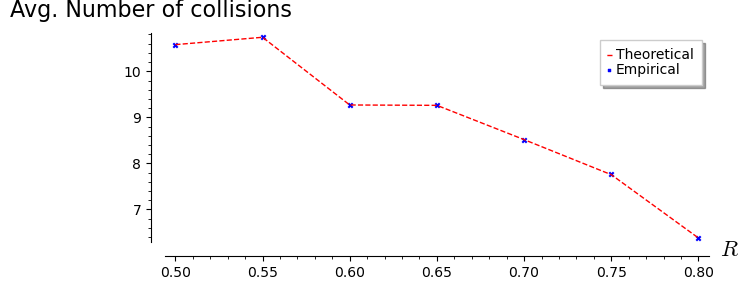

In [10]:
seed = 0; #choose seed for simulation
set_random_seed(seed)

R_int_min = 50; R_int_max = 80; R_step = 5; #rate parameters

n_in = 100; #code length
num_instances = 100; #number of RSD instances per each considered rate value

th_vals = []; emp_vals = []; #values which will be later visualized

for R_int in range(R_int_min, R_int_max+1, R_step):
    
    
    n, k, w, b = RSD_params_uniqueness_bound(n_in, R_int/100) #get RSD parameters
    
    print("Considering: w/n = ",N(w/n+0.),", [n, k, w, b] = "+str([n, k, w, b]));
    
    S = max(1, b**w*2**(-(n-k)))#expected number of solutions
    
    k_prime = k-w; #new dimension, due to regularity-encoding equations
    
    if k_prime < 0: #if k_prime < 0, abort simulation
        print("!!! k < w: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        continue;
        
    min_cost, params, quantities = enumeration_based_concrete_cost_rounding(n, k, w, b, S); #theoretical estimates

    p = params[0]; ell = params[1]; v = params[2]; w_f_left = params[3]; w_c_left = params[4]; w_f_right = params[5]; w_c_right = params[6];
    L1 = quantities[0]; L2 = quantities[1]; num_coll = quantities[2]; p_iter = quantities[3];
    
    if p==0: #best algoritm is PERM-based: abort simulation
        print("!!! Optimal p = 0: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        
    print("Setting: p = "+str(p)+", ell = "+str(ell),", |L1| = 2^"+str(L1)+", |L2| = 2^"+str(L2));

    all_vecs_left = all_regular_initial_list(p/2, w_f_left, v, w_c_left, v+1);
    all_vecs_right = all_regular_initial_list(p/2, w_f_right, v, w_c_right, v+1);

    #Necessary later, when calling ENUM-based ISD
    params = [p, ell, w_f_left, w_c_left, w_f_right, w_c_right, v, v+1]

    num_success = 0; #number of successful iterations
    num_full_rank = 0; #num of full rank matrices in ISD
    num_PGE_ok = 0; #number of H' with full ranks
    avg_num_coll = 0; #average number of collisions
    min_num_coll = 100000000000000 #min number of collisions
    max_num_coll = -100000000000000 #min number of collisions
    
    for id_instance in range(1, num_instances+1):

        #Sample RSD instance
        H, e, s = sample_rsdp_instance(n, k, b, w)

        #Add parity-chek equations
        new_H, new_s = add_parity_checks(H, s, n, k, b, w)

        #Launch ENUM-based ISD
        num_success, num_full_rank, num_PGE_ok, avg_num_coll, max_num_coll, min_num_coll = ENUM_based_ISD(n, k_prime, w, b, new_H, new_s, all_vecs_left, all_vecs_right, params, num_success, num_full_rank, num_PGE_ok, avg_num_coll, min_num_coll, max_num_coll);

    print("log2(Num_coll): Theoretical: ",N(num_coll))
    print("Experimental values:");
    print("log2(Min_num_coll): ",N(min_num_coll),"log2(Avg_num_coll): ",N(log(avg_num_coll/num_PGE_ok,2)),", log2(Max_num_coll): ",N(max_num_coll));
    
    th_vals.append((R_int/100, num_coll))
    emp_vals.append((R_int/100, log(avg_num_coll/num_PGE_ok,2)))

    print("-------------------------------------------------------------------------------------");
    
g = list_plot(th_vals, color = 'red', linestyle = "--", plotjoined = True, legend_label = 'Theoretical')
g += list_plot(emp_vals, marker = 'x', legend_label = 'Empirical')
g.show(axes_labels =  ["$R$","Avg. Number of collisions"], figsize = [7.5,3])

# Now testing $R < 1-\frac{1}{e\ln(2)}$

We fix the code rate and test several values for $w$

Considering: w/n =  0.0500000000000000 , [n, k, w, b] = [100, 40, 5, 20]
Setting: p = 2, ell = 4 , |L1| = 2^4.00000000000000, |L2| = 2^4.52356195605701
log2(Num_coll): Theoretical:  4.52356195605701
Experimental values:
log2(Min_num_coll):  3.58496250072116 log2(Avg_num_coll):  4.50057031343078 , log2(Max_num_coll):  5.12928301694497
-------------------------------------------------------------------------------------
Considering: w/n =  0.0714285714285714 , [n, k, w, b] = [98, 39, 7, 14]
Setting: p = 2, ell = 2 , |L1| = 2^3.90689059560852, |L2| = 2^4.24792751344359
log2(Num_coll): Theoretical:  6.15481810905210
Experimental values:
log2(Min_num_coll):  5.70043971814109 log2(Avg_num_coll):  6.14834508339736 , log2(Max_num_coll):  6.37503943134693
-------------------------------------------------------------------------------------
Considering: w/n =  0.0909090909090909 , [n, k, w, b] = [99, 39, 9, 11]
Setting: p = 2, ell = 1 , |L1| = 2^3.80735492205760, |L2| = 2^4.08746284125034
log2(N

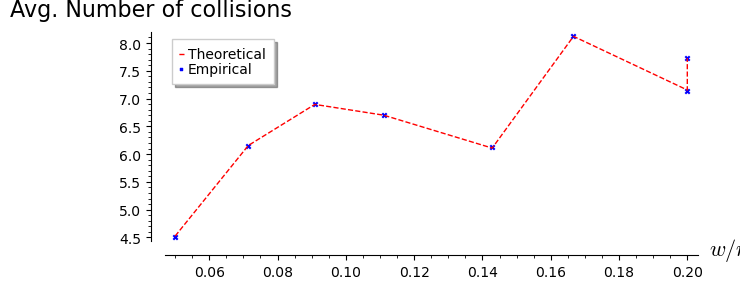

In [11]:
seed = 0; #choose seed for simulation
set_random_seed(seed)


#Parameters
omega_int_min = 5; omega_int_max = 19; omega_int_step = 2;

R = 0.4 #fixed code rate
n_in = 100; #code length

num_instances = 100; #number of RSD instances per each considered rate value

th_vals = []; emp_vals = [];

for omega_int in range(omega_int_min, omega_int_max+1, omega_int_step):
    
    n = n_in
    
    w = round(omega_int/100*n)
    
    #adjust parameters so that b divides n
    n = w*floor(n/w); k = floor(n*R); b = n/w
    
    print("Considering: w/n = ",N(w/n+0.),", [n, k, w, b] = "+str([n, k, w, b]));
    S = max(1,b**w/(2**(n-k))); #number of solutions
    
    k_prime = k-w; #new dimension, due to regularity-encoding equations
    
    if k_prime < 0: #if k_prime < 0, abort simulation
        print("!!! k < w: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        continue;
        
    min_cost, params, quantities = enumeration_based_concrete_cost_rounding(n, k, w, b, S); #theoretical estimates

    p = params[0]; ell = params[1]; v = params[2]; w_f_left = params[3]; w_c_left = params[4]; w_f_right = params[5]; w_c_right = params[6];
    L1 = quantities[0]; L2 = quantities[1]; num_coll = quantities[2]; p_iter = quantities[3];
    
    if p==0: #best algoritm is PERM-based: abort simulation
        print("!!! Optimal p = 0: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        
    print("Setting: p = "+str(p)+", ell = "+str(ell),", |L1| = 2^"+str(L1)+", |L2| = 2^"+str(L2));    
        
    #Generate all vectors for enumeration (we do this once, before generating RSD instances and launching the code)
    all_vecs_left = all_regular_initial_list(p/2, w_f_left, v, w_c_left, v+1);
    all_vecs_right = all_regular_initial_list(p/2, w_f_right, v, w_c_right, v+1);

    #Necessary later, when calling ENUM-based ISD
    params = [p, ell, w_f_left, w_c_left, w_f_right, w_c_right, v, v+1]

    num_success = 0; #number of successful iterations
    num_full_rank = 0; #num of full rank matrices in ISD
    num_PGE_ok = 0; #number of H' with full ranks
    avg_num_coll = 0; #average number of collisions
    min_num_coll = 100000000000000 #min number of collisions
    max_num_coll = -100000000000000 #min number of collisions
    
    for id_instance in range(1, num_instances+1):
        
      
        #Sample RSD instance
        H, e, s = sample_rsdp_instance(n, k, b, w);

        #Add parity-chek equations
        new_H, new_s = add_parity_checks(H, s, n, k, b, w);

          #Launch ENUM-based ISD
        num_success, num_full_rank, num_PGE_ok, avg_num_coll, max_num_coll, min_num_coll = ENUM_based_ISD(n, k_prime, w, b, new_H, new_s, all_vecs_left, all_vecs_right, params, num_success, num_full_rank, num_PGE_ok, avg_num_coll, min_num_coll, max_num_coll);

    print("log2(Num_coll): Theoretical: ",N(num_coll))
    print("Experimental values:");
    print("log2(Min_num_coll): ",N(min_num_coll),"log2(Avg_num_coll): ",N(log(avg_num_coll/num_PGE_ok,2)),", log2(Max_num_coll): ",N(max_num_coll));
    
    th_vals.append((w/n, num_coll))
    emp_vals.append((w/n, log(avg_num_coll/num_PGE_ok,2)))

    print("-------------------------------------------------------------------------------------");

g = list_plot(th_vals, color = 'red', linestyle = "--", plotjoined = True, legend_label = 'Theoretical')
g += list_plot(emp_vals, marker = 'x', legend_label = 'Empirical')
g.show(axes_labels =  ["$w/n$","Avg. Number of collisions"], figsize = [7.5,3])